# 주식예측 : 삼성주식 예측

#### Dataset : Yahoo Financial 
#### Link : https://finance.yahoo.com/quote/005930.KS?p=005930.KS&.tsrc=fin-srch

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

### Load Dataset

In [16]:
data = pd.read_csv('dataset/005930.KS.5y.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-09,36600.0,37500.0,36560.0,37220.0,32445.269531,13194900
1,2017-01-10,37280.0,37400.0,37080.0,37240.0,32462.695313,9099800
2,2017-01-11,37520.0,38560.0,37420.0,38280.0,33369.281250,12018150
3,2017-01-12,38000.0,38800.0,37980.0,38800.0,33822.574219,11669150
4,2017-01-13,38100.0,38320.0,37460.0,37460.0,32654.482422,15954450


### Compute Mid Price

In [17]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

### Create Windows
#### 최근 50일간의 데이터를 보고 예측하는 것 
#### 50일 = Window size, 즉 50개를 보고 한개를 예측하는 것
#### 우선 51개씩 묶고, 

In [19]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    # 51개씩 한개씩 예측하는 것 
    result.append(mid_prices[index: index + sequence_length])

### Normalize Data <br>
##### 정규화하는 작업이 필요함 그래야 예측률이 높아짐
##### window 맨처음을 값을 0을 만들고, 정규화된 window를 얻게됨 
##### 그다음에 training set 과 test set이 필요함 
##### test set은 검증데이터이기에 절대로 training set과 섞이면 안된다. 

In [20]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1058, 50, 1), (117, 50, 1))

1058일을 이용해 117일을 예측하는 것

# Build a Model

In [21]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

2022-01-09 17:55:54.074209: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [22]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
106/106 [==============================] - 12s 52ms/step - loss: 0.0021 - val_loss: 7.3614e-04
Epoch 2/20
106/106 [==============================] - 5s 45ms/step - loss: 0.0010 - val_loss: 4.4046e-04
Epoch 3/20
106/106 [==============================] - 5s 50ms/step - loss: 6.8563e-04 - val_loss: 3.4551e-04
Epoch 4/20
106/106 [==============================] - 6s 52ms/step - loss: 5.7880e-04 - val_loss: 3.9340e-04
Epoch 5/20
106/106 [==============================] - 6s 60ms/step - loss: 4.6527e-04 - val_loss: 3.2599e-04
Epoch 6/20
106/106 [==============================] - 8s 71ms/step - loss: 3.8400e-04 - val_loss: 1.5750e-04
Epoch 7/20
106/106 [==============================] - 6s 57ms/step - loss: 3.4553e-04 - val_loss: 2.1565e-04
Epoch 8/20
106/106 [==============================] - 6s 61ms/step - loss: 3.4593e-04 - val_loss: 1.7190e-04
Epoch 9/20
106/106 [==============================] - 6s 55ms/step - loss: 3.1479e-04 - val_loss: 2.1990e-04
Epoch 10/20
106/106 [=====

# Prediction

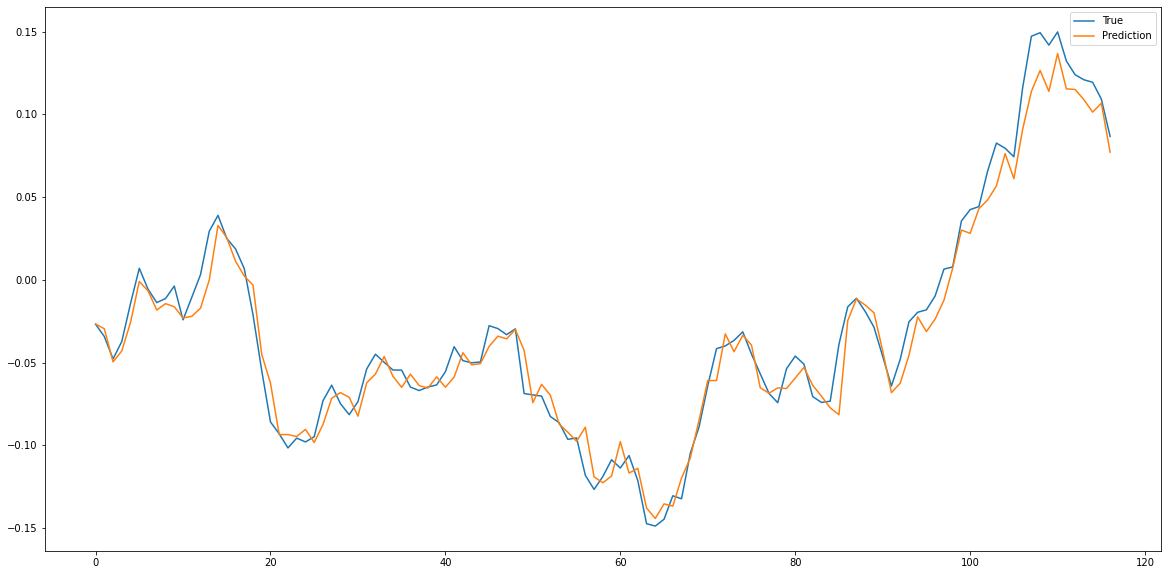

In [23]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()